In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
print(f"CUDA_LAUNCH_BLOCKING is set to: {os.environ.get('CUDA_LAUNCH_BLOCKING')}")


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.transforms.v2 as transforms_v2
import matplotlib.pyplot as plt

from google.colab import files
files.upload()

try:
    from engine import create_dataloaders, train_and_evaluate, save_model

except ImportError:
    print("Could not import from train.py. Ensure it's uploaded or correctly path-ed.")


# Rest of your global variables
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = int(os.cpu_count())
BATCH_SIZE = 256
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.406]
EPOCHS = 100
print(f"Using {DEVICE} device")

CUDA_LAUNCH_BLOCKING is set to: 1


Saving engine.py to engine (1).py
Using cuda device


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

tgt_transforms = transforms_v2.Compose([
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(MEAN, STD)
])

In [4]:
class  CIFAR100StrongNet(nn.Module):
  def __init__(self, in_channels:int,base_channels: int, out_channels:int ):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=base_channels, kernel_size=3, stride=1),
        nn.BatchNorm2d(num_features=base_channels),
        nn.ReLU(),
        nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(base_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.3))

    self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))
    self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))
    self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(),
            nn.Conv2d(base_channels * 8, base_channels * 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

    # Calculate flattened size dynamically for 32x32 input
    dummy_input = torch.randn(1, in_channels, 32, 32)
    with torch.no_grad():
        x = self.conv_layer_1(dummy_input)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
    flattened_size = x.numel()
    print(f"Calculated flattened size for nn.Linear: {flattened_size}\n")

    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(in_features=1024, out_features=out_channels)
        )
  def forward(self, x):
      x = self.conv_layer_1(x)
      x = self.conv_layer_2(x)
      x = self.conv_layer_3(x)
      x = self.conv_layer_4(x)
      return self.classifier(x)

model =  CIFAR100StrongNet(3, 64, 100) # -> (Color_Channels, Base_Channels, Num_Classes)
model.to(DEVICE)
# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Num parameters : {count_parameters(model)}")

Calculated flattened size for nn.Linear: 512

Num parameters : 5319076


100%|██████████| 169M/169M [00:12<00:00, 13.1MB/s]


Calculated flattened size for nn.Linear: 1024

Epoch 1
---------------------------------------
Train Loss: 4.3745, Accuracy: 4.67%
Val Loss: 4.0313, Accuracy: 9.03%
✅ Best model saved! Accuracy: 0.09
Epoch 2
---------------------------------------
Train Loss: 3.9375, Accuracy: 11.20%
Val Loss: 3.6204, Accuracy: 17.13%
✅ Best model saved! Accuracy: 0.17
Epoch 3
---------------------------------------
Train Loss: 3.6189, Accuracy: 17.68%
Val Loss: 3.2956, Accuracy: 25.16%
✅ Best model saved! Accuracy: 0.25
Epoch 4
---------------------------------------
Train Loss: 3.3509, Accuracy: 24.00%
Val Loss: 2.9611, Accuracy: 34.01%
✅ Best model saved! Accuracy: 0.34
Epoch 5
---------------------------------------
Train Loss: 3.1528, Accuracy: 29.02%
Val Loss: 2.8528, Accuracy: 36.61%
✅ Best model saved! Accuracy: 0.37
Epoch 6
---------------------------------------
Train Loss: 2.9980, Accuracy: 33.01%
Val Loss: 2.7251, Accuracy: 40.27%
✅ Best model saved! Accuracy: 0.40
Epoch 7
-----------------

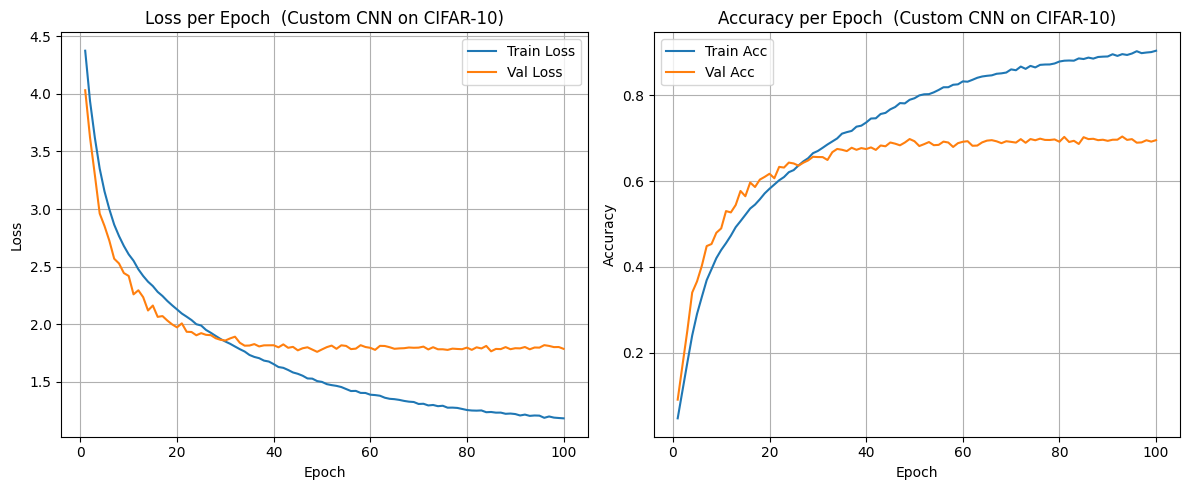

📦 Final model saved to final_model.pth


In [5]:
train_loader, test_loader = create_dataloaders(
    dataset_class=datasets.CIFAR100,
    root="data/",
    train_transforms=train_transforms,
    test_transforms=tgt_transforms,
    batch_size=256,
    num_workers=NUM_WORKERS
)

model = CIFAR100StrongNet(3, 128, 100).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    steps_per_epoch=len(train_loader),
    epochs=100,
    anneal_strategy="cos"
)

train_and_evaluate(EPOCHS, scheduler, train_loader, test_loader, model, loss_fn, optimizer, DEVICE)
save_model(model)